# Setting Up

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

In [2]:
water_df = pd.read_csv("/content/water_potability nan mu.csv")

In [3]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
water_df.head().T.style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
ph,nan,3.716080,8.099124,8.316766,9.092223
Hardness,204.890455,129.422921,224.236259,214.373394,181.101509
Solids,20791.318981,18630.057858,19909.541732,22018.417441,17978.986339
Chloramines,7.300212,6.635246,9.275884,8.059332,6.546600
Sulfate,368.516441,nan,nan,356.886136,310.135738
Conductivity,564.308654,592.885359,418.606213,363.266516,398.410813
Organic_carbon,10.379783,15.180013,16.868637,18.436524,11.558279
Trihalomethanes,86.990970,56.329076,66.420093,100.341674,31.997993
Turbidity,2.963135,4.500656,3.055934,4.628771,4.075075
Potability,0.000000,0.000000,0.000000,0.000000,0.000000


Checking Missing Values

<Axes: >

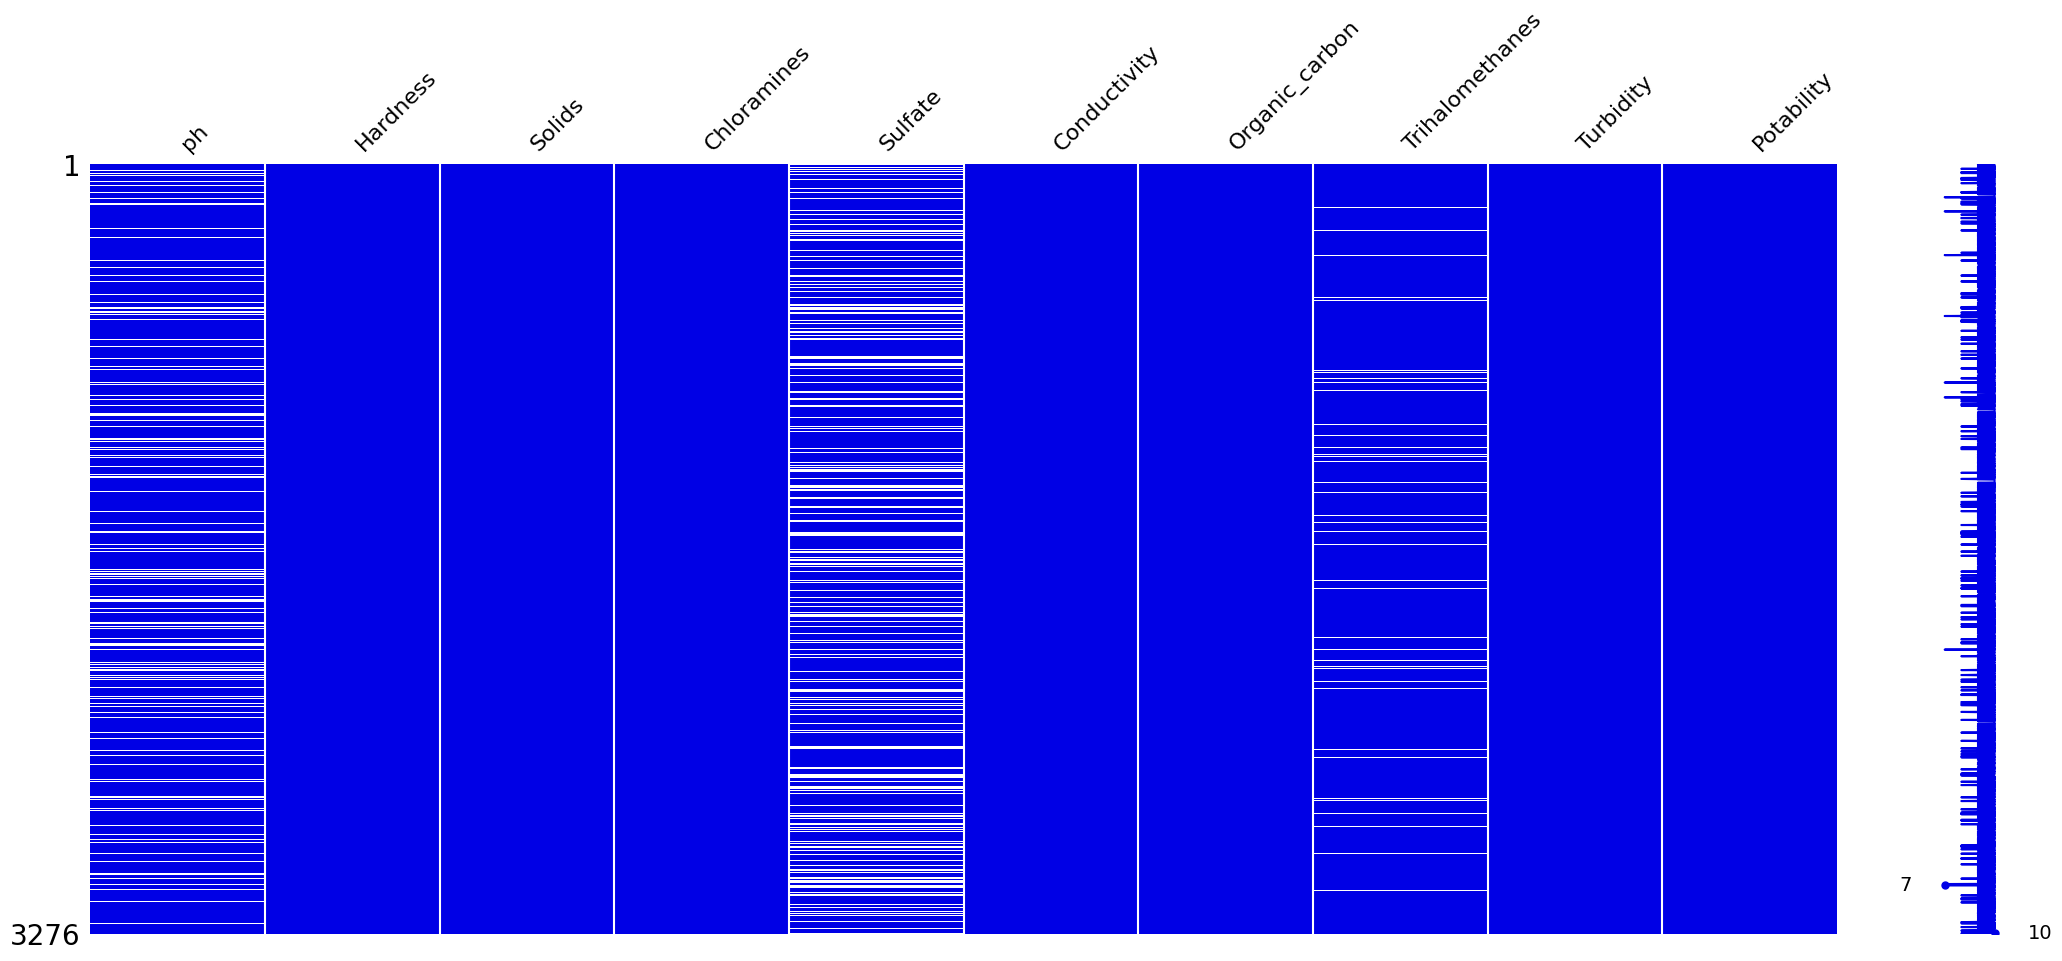

In [5]:
import missingno as msno
msno.matrix(water_df,color=(0.0, 0.0, 0.9))

Observation:

There are missing values for ph, sulfate, and trihalomethanes.

## EDA

# Checking the data type of features

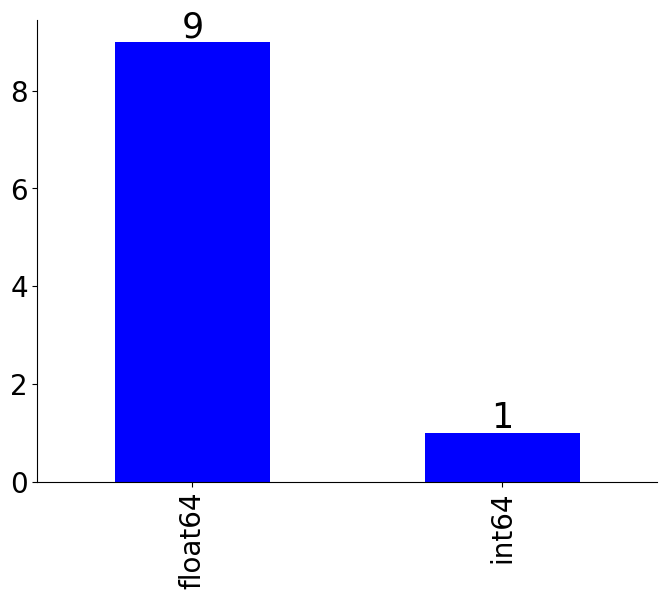

In [6]:
plt.figure(figsize = (8,6))
ax = water_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='blue')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 0.1, height, ha = 'center', size = 25)
sns.despine()

Observation:

All are numerical features.

Checking Target Imbalance

In [7]:
colors = ['gold', 'mediumturquoise']
labels = ['No','Yes']
values = water_df['Potability'].value_counts()/water_df['Potability'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Potability",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="blue",
    plot_bgcolor='blue',
    font_color="white",
)
fig.show()

Observation:

OK! Target is balanced!

Numerical Features

In [8]:
def get_condition(feature):
    q1, q3 = water_df.loc[water_df['Potability'] == 1, feature].quantile([0.25,0.75])
    print(q1,q3)
    condition = (water_df[feature] >= q1) & (water_df[feature] <= q3)
    return condition

In [9]:
def display_stat(feature):
    mean = water_df[feature].mean()
    std = water_df[feature].std()
    skew = water_df[feature].skew()
    kurtosis = water_df[feature].kurtosis()
    print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))

In [10]:
def plot_histgram(feature):
    fig = px.histogram(water_df, x=feature,
                       color="Potability",
                       marginal="box",
                       barmode ="overlay",
                       histnorm ='density'
                      )
    fig.update_layout(
        title={
            'text': feature+" histogram",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
    )
    fig.show()

ph (pH value)

In [11]:
plot_histgram('ph')
display_stat('ph')

mean: 7.0808, std: 1.5943, skew: 0.0256, kurtosis: 0.7203 


Observation:

If you look at the picture above, there are cases where it is judged that you can drink even if the pH is less than 6 or greater than 8.5.
There is no significant difference in the distribution of water potability according to pH.

Derived Feature ( is_ph_ok )
We want to record the data included in the IQR of ph that is judged to be drinkable by creating a derived feature called is_ph_ok.

In [12]:
condition = get_condition('ph')

6.179312077651539 7.933067691513921


Observation:

Among the data, the pH values between 6.28 and 7.89 are included in the IQR

In [13]:
water_df['is_ph_ok'] = 0
water_df.loc[condition, 'is_ph_ok'] = 1
water_df['is_ph_ok'].value_counts()

0    2027
1    1249
Name: is_ph_ok, dtype: int64

# Hardness

In [14]:
plot_histgram('Hardness')
display_stat('Hardness')

mean: 196.3695, std: 32.8798, skew: -0.0393, kurtosis: 0.6158 


Observation:

There is no significant difference in the distribution of water potability according to Hardness.

Derived Feature ( is_Hardness_ok )
We want to record the data included in the IQR of Hardness that is judged to exist by creating a derived feature called is_Hardness_ok.

In [15]:
condition = get_condition('Hardness')

174.33053144229612 218.00342038709096


Observation:

Among the data, the Hardness values between 176.74 and 217.73 are included in the IQR.

In [16]:
water_df['is_Hardness_ok'] = 0
water_df.loc[condition, 'is_Hardness_ok'] = 1
water_df['is_Hardness_ok'].value_counts()

1    1742
0    1534
Name: is_Hardness_ok, dtype: int64

# Solids

In [17]:
plot_histgram('Solids')
display_stat('Solids')

mean: 22014.0925, std: 8768.5708, skew: 0.6216, kurtosis: 0.4428 


Observation:

There is no significant difference in the distribution of water potability according to Solids.

Derived Feature ( is_Solids_ok )
We want to record the data included in the IQR of Hardness that is judged to be drinkable by creating a derived feature called is_Solids_ok.

In [18]:
condition = get_condition('Solids')

15668.985034874642 27973.236446407398


Observation:

Among the data, the Solids values between 15665.10 and 27249.84 are included in the IQR.

In [19]:
water_df['is_Solids_ok'] = 0
water_df.loc[condition, 'is_Solids_ok'] = 1
water_df['is_Solids_ok'].value_counts()

1    1707
0    1569
Name: is_Solids_ok, dtype: int64

# Chloramines


In [20]:
plot_histgram('Chloramines')
display_stat('Chloramines')

mean: 7.1223, std: 1.5831, skew: -0.0121, kurtosis: 0.5899 


Observation:

There is no significant difference in the distribution of water potability according to Chloramines.

Derived Feature ( is_Chloramines_ok )
We intend to record the data included in the IQR of Chloramines that are judged to be drinkable by creating a derived feature called is_Chloramines_ok.

In [21]:
condition = get_condition('Chloramines')

6.094133563248015 8.199261442679553


Observation:

Among the data, the Chloramines values between 6.17 and 8.10 are included in the IQR

In [22]:
water_df['is_Chloramines_ok'] = 0
water_df.loc[condition, 'is_Chloramines_ok'] = 1
water_df['is_Chloramines_ok'].value_counts()

1    1721
0    1555
Name: is_Chloramines_ok, dtype: int64

# Sulfate

In [23]:
plot_histgram('Sulfate')
display_stat('Sulfate')

mean: 333.7758, std: 41.4168, skew: -0.0359, kurtosis: 0.6483 


Derived Feature ( is_Sulfate_ok )
 We want to record the data included in Sulfate's IQR, which is judged to be drinkable, by creating a derived feature called is_Sulfate_ok.

In [24]:
condition = get_condition('Sulfate')

300.7637719072286 365.9413461121188


Observation:

Among the data, the Sulfate values between 304.97 and 364.57 are included in the IQR.

In [25]:
water_df['is_Sulfate_ok'] = 0
water_df.loc[condition, 'is_Sulfate_ok'] = 1
water_df['is_Sulfate_ok'].value_counts()

0    1811
1    1465
Name: is_Sulfate_ok, dtype: int64

# Conductivity

In [26]:
plot_histgram('Conductivity')
display_stat('Conductivity')

mean: 426.2051, std: 80.8241, skew: 0.2645, kurtosis: -0.2771 


Derived Feature ( is_Conductivity_ok )
We want to record the data included in the IQR of Conductivity that is judged to be drinkable by creating an is_Conductivity_ok derived feature.

In [27]:
condition = get_condition('Conductivity')

360.9390225594526 484.15591109520597


Observation:

Among the data, the Conductivity values between 359.51 and 481.41 are included in the IQR.

In [28]:
water_df['is_Conductivity_ok'] = 0
water_df.loc[condition, 'is_Conductivity_ok'] = 1
water_df['is_Conductivity_ok'].value_counts()

1    1724
0    1552
Name: is_Conductivity_ok, dtype: int64

# Organic_carbon

In [29]:
plot_histgram('Organic_carbon')
display_stat('Organic_carbon')

mean: 14.2850, std: 3.3082, skew: 0.0255, kurtosis: 0.0444 


Derived Feature ( is_Organic_carbon_ok )

In [30]:
condition = get_condition('Organic_carbon')

12.033897118881185 16.356245435100547


Observation:

Among the data, the Organic_carbon values between 12.28 and 16.63 are included in the IQR.

In [31]:
water_df['is_Organic_carbon_ok'] = 0
water_df.loc[condition, 'is_Organic_carbon_ok'] = 1
water_df['is_Organic_carbon_ok'].value_counts()

0    1676
1    1600
Name: is_Organic_carbon_ok, dtype: int64

# Trihalomethanes

In [32]:
plot_histgram('Trihalomethanes')
display_stat('Trihalomethanes')

mean: 66.3963, std: 16.1750, skew: -0.0830, kurtosis: 0.2386 


Derived Feature ( is_Trihalomethanes_ok )
We want to record the data included in the IQR of Trihalomethanes that are judged to be drinkable by creating a derived feature called is_Trihalomethanes_ok.

In [33]:
condition = get_condition('Trihalomethanes')

56.01424900497346 77.38097531174441


Observation:

Among the data, the Sulfate values between 56.45 and 77.41 are included in the IQR.

In [34]:
water_df['is_Trihalomethanes_ok'] = 0
water_df.loc[condition, 'is_Trihalomethanes_ok'] = 1
water_df['is_Trihalomethanes_ok'].value_counts()

0    1728
1    1548
Name: is_Trihalomethanes_ok, dtype: int64

# Turbidity

In [35]:
plot_histgram('Turbidity')
display_stat('Turbidity')

mean: 3.9668, std: 0.7804, skew: -0.0078, kurtosis: -0.0628 


Derived Feature ( is_Turbidity_ok )
We want to record the data included in the IQR of Turbidity, which is judged to be drinkable, by creating a derived feature called is_Turbidity_ok.

In [36]:
condition = get_condition('Turbidity')

3.430909338727502 4.509568597447933


Observation:

Among the data, the Sulfate values between 3.48 and 4.53 are included in the IQR.

In [37]:
water_df['is_Turbidity_ok'] = 0
water_df.loc[condition, 'is_Turbidity_ok'] = 1
water_df['is_Turbidity_ok'].value_counts()

1    1658
0    1618
Name: is_Turbidity_ok, dtype: int64

# Checking Feature Importance
Here we check feature importance in various ways.

Knowing which features are important when judging heart disease from different features will help you make a decision. It will also be very helpful when explaining to people who have been diagnosed.

In [38]:
plt.figure(figsize=(20,20))
corr=water_df.corr().round(2)
fig = px.imshow(corr)
fig.update_layout(
    title_text="Water Potability",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="blue",
    plot_bgcolor='blue',
    font_color="white",
)
fig.show()

<Figure size 2000x2000 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

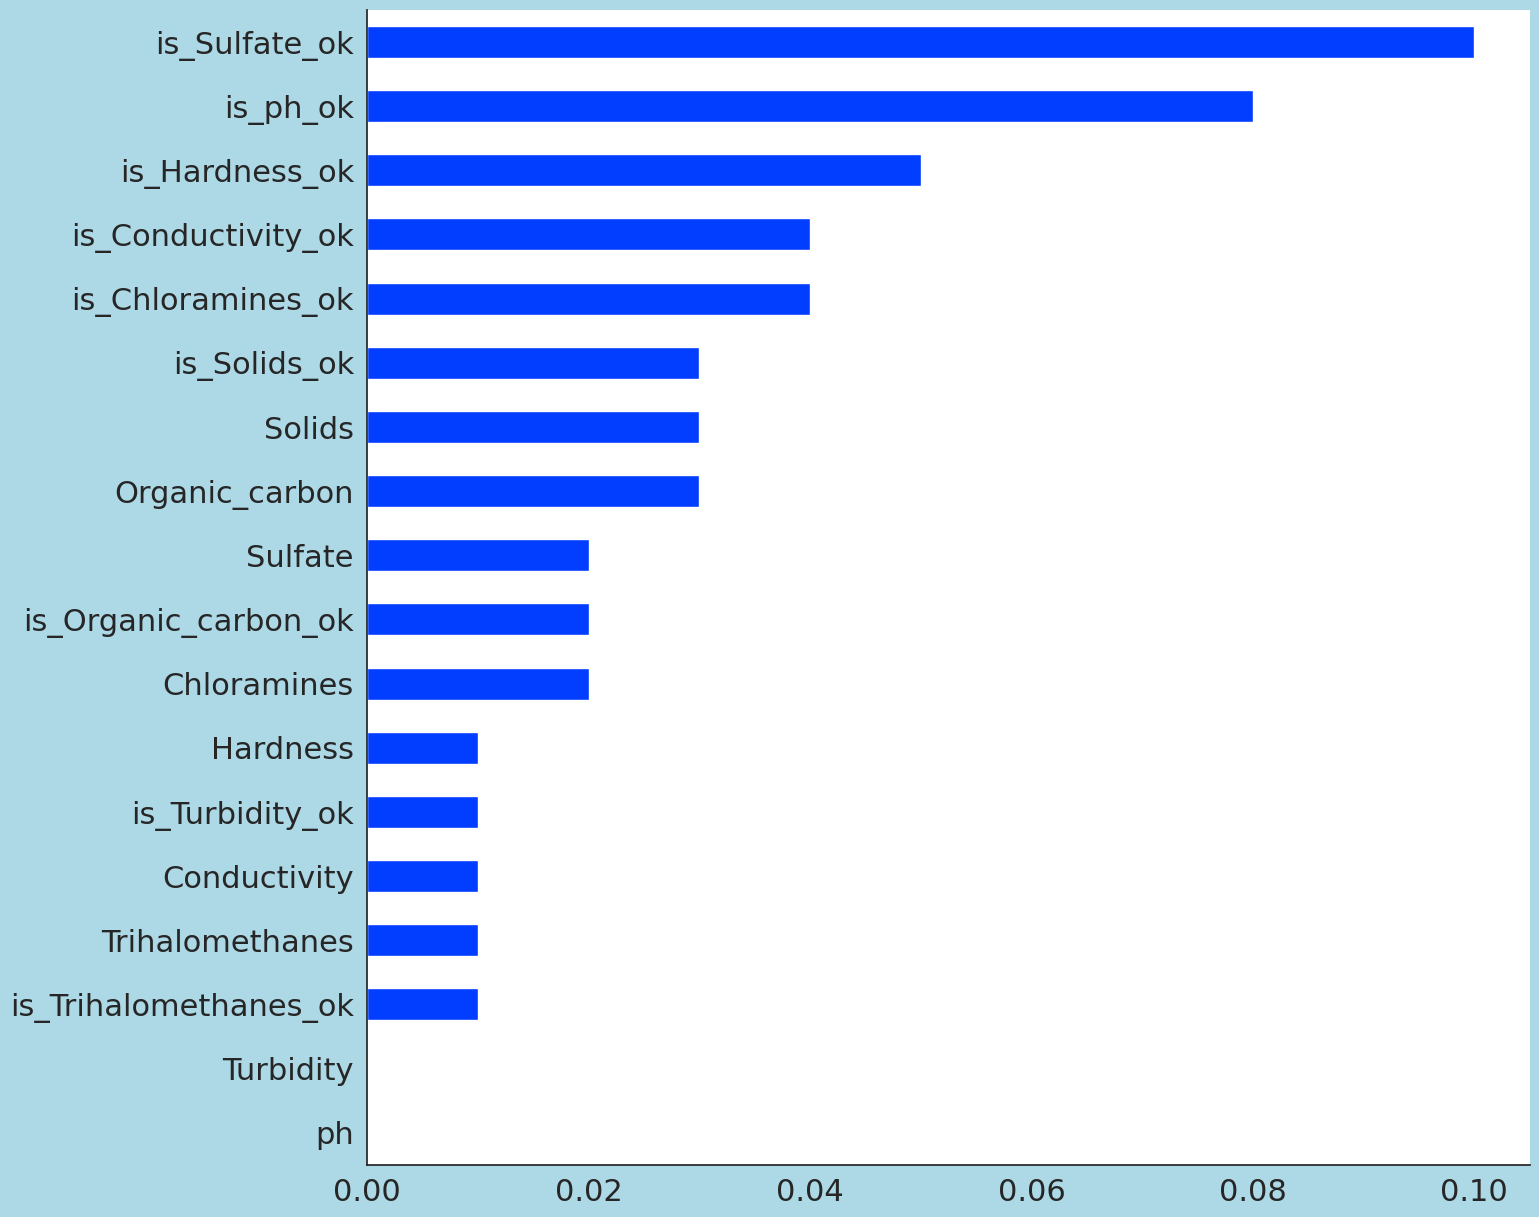

In [39]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
plt.rcParams['figure.facecolor'] = 'lightblue'
fig,ax = plt.subplots(figsize=(15,15))
abs(corr['Potability']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
sns.despine()

Observation:

The correlation coefficient of all features is low.
Correlation coefficients of newly created derived features are relatively high.

Observation:

The correlation coefficient of all features is low.
Correlation coefficients of newly created derived features are relatively high.

check missing value

In [40]:
water_df.isnull().sum()

ph                       491
Hardness                   0
Solids                     0
Chloramines                0
Sulfate                  781
Conductivity               0
Organic_carbon             0
Trihalomethanes          162
Turbidity                  0
Potability                 0
is_ph_ok                   0
is_Hardness_ok             0
is_Solids_ok               0
is_Chloramines_ok          0
is_Sulfate_ok              0
is_Conductivity_ok         0
is_Organic_carbon_ok       0
is_Trihalomethanes_ok      0
is_Turbidity_ok            0
dtype: int64

Imputation of missing value

In [41]:
water_df['ph'] = water_df['ph'].fillna(water_df['ph'].mean())

In [42]:
water_df['Sulfate'] = water_df['Sulfate'].fillna(water_df['Sulfate'].mean())

In [43]:
water_df['Trihalomethanes'] = water_df['Trihalomethanes'].fillna(water_df['Trihalomethanes'].mean())

After imputation

In [44]:
water_df.isnull().sum()

ph                       0
Hardness                 0
Solids                   0
Chloramines              0
Sulfate                  0
Conductivity             0
Organic_carbon           0
Trihalomethanes          0
Turbidity                0
Potability               0
is_ph_ok                 0
is_Hardness_ok           0
is_Solids_ok             0
is_Chloramines_ok        0
is_Sulfate_ok            0
is_Conductivity_ok       0
is_Organic_carbon_ok     0
is_Trihalomethanes_ok    0
is_Turbidity_ok          0
dtype: int64

Feature importance based on feature permutation

In [45]:
water_df_copy = water_df.copy()
X_train = water_df_copy.drop('Potability',axis=1)
y_train = water_df_copy.pop('Potability')

In [46]:
all_cols = [cname for cname in X_train.columns]

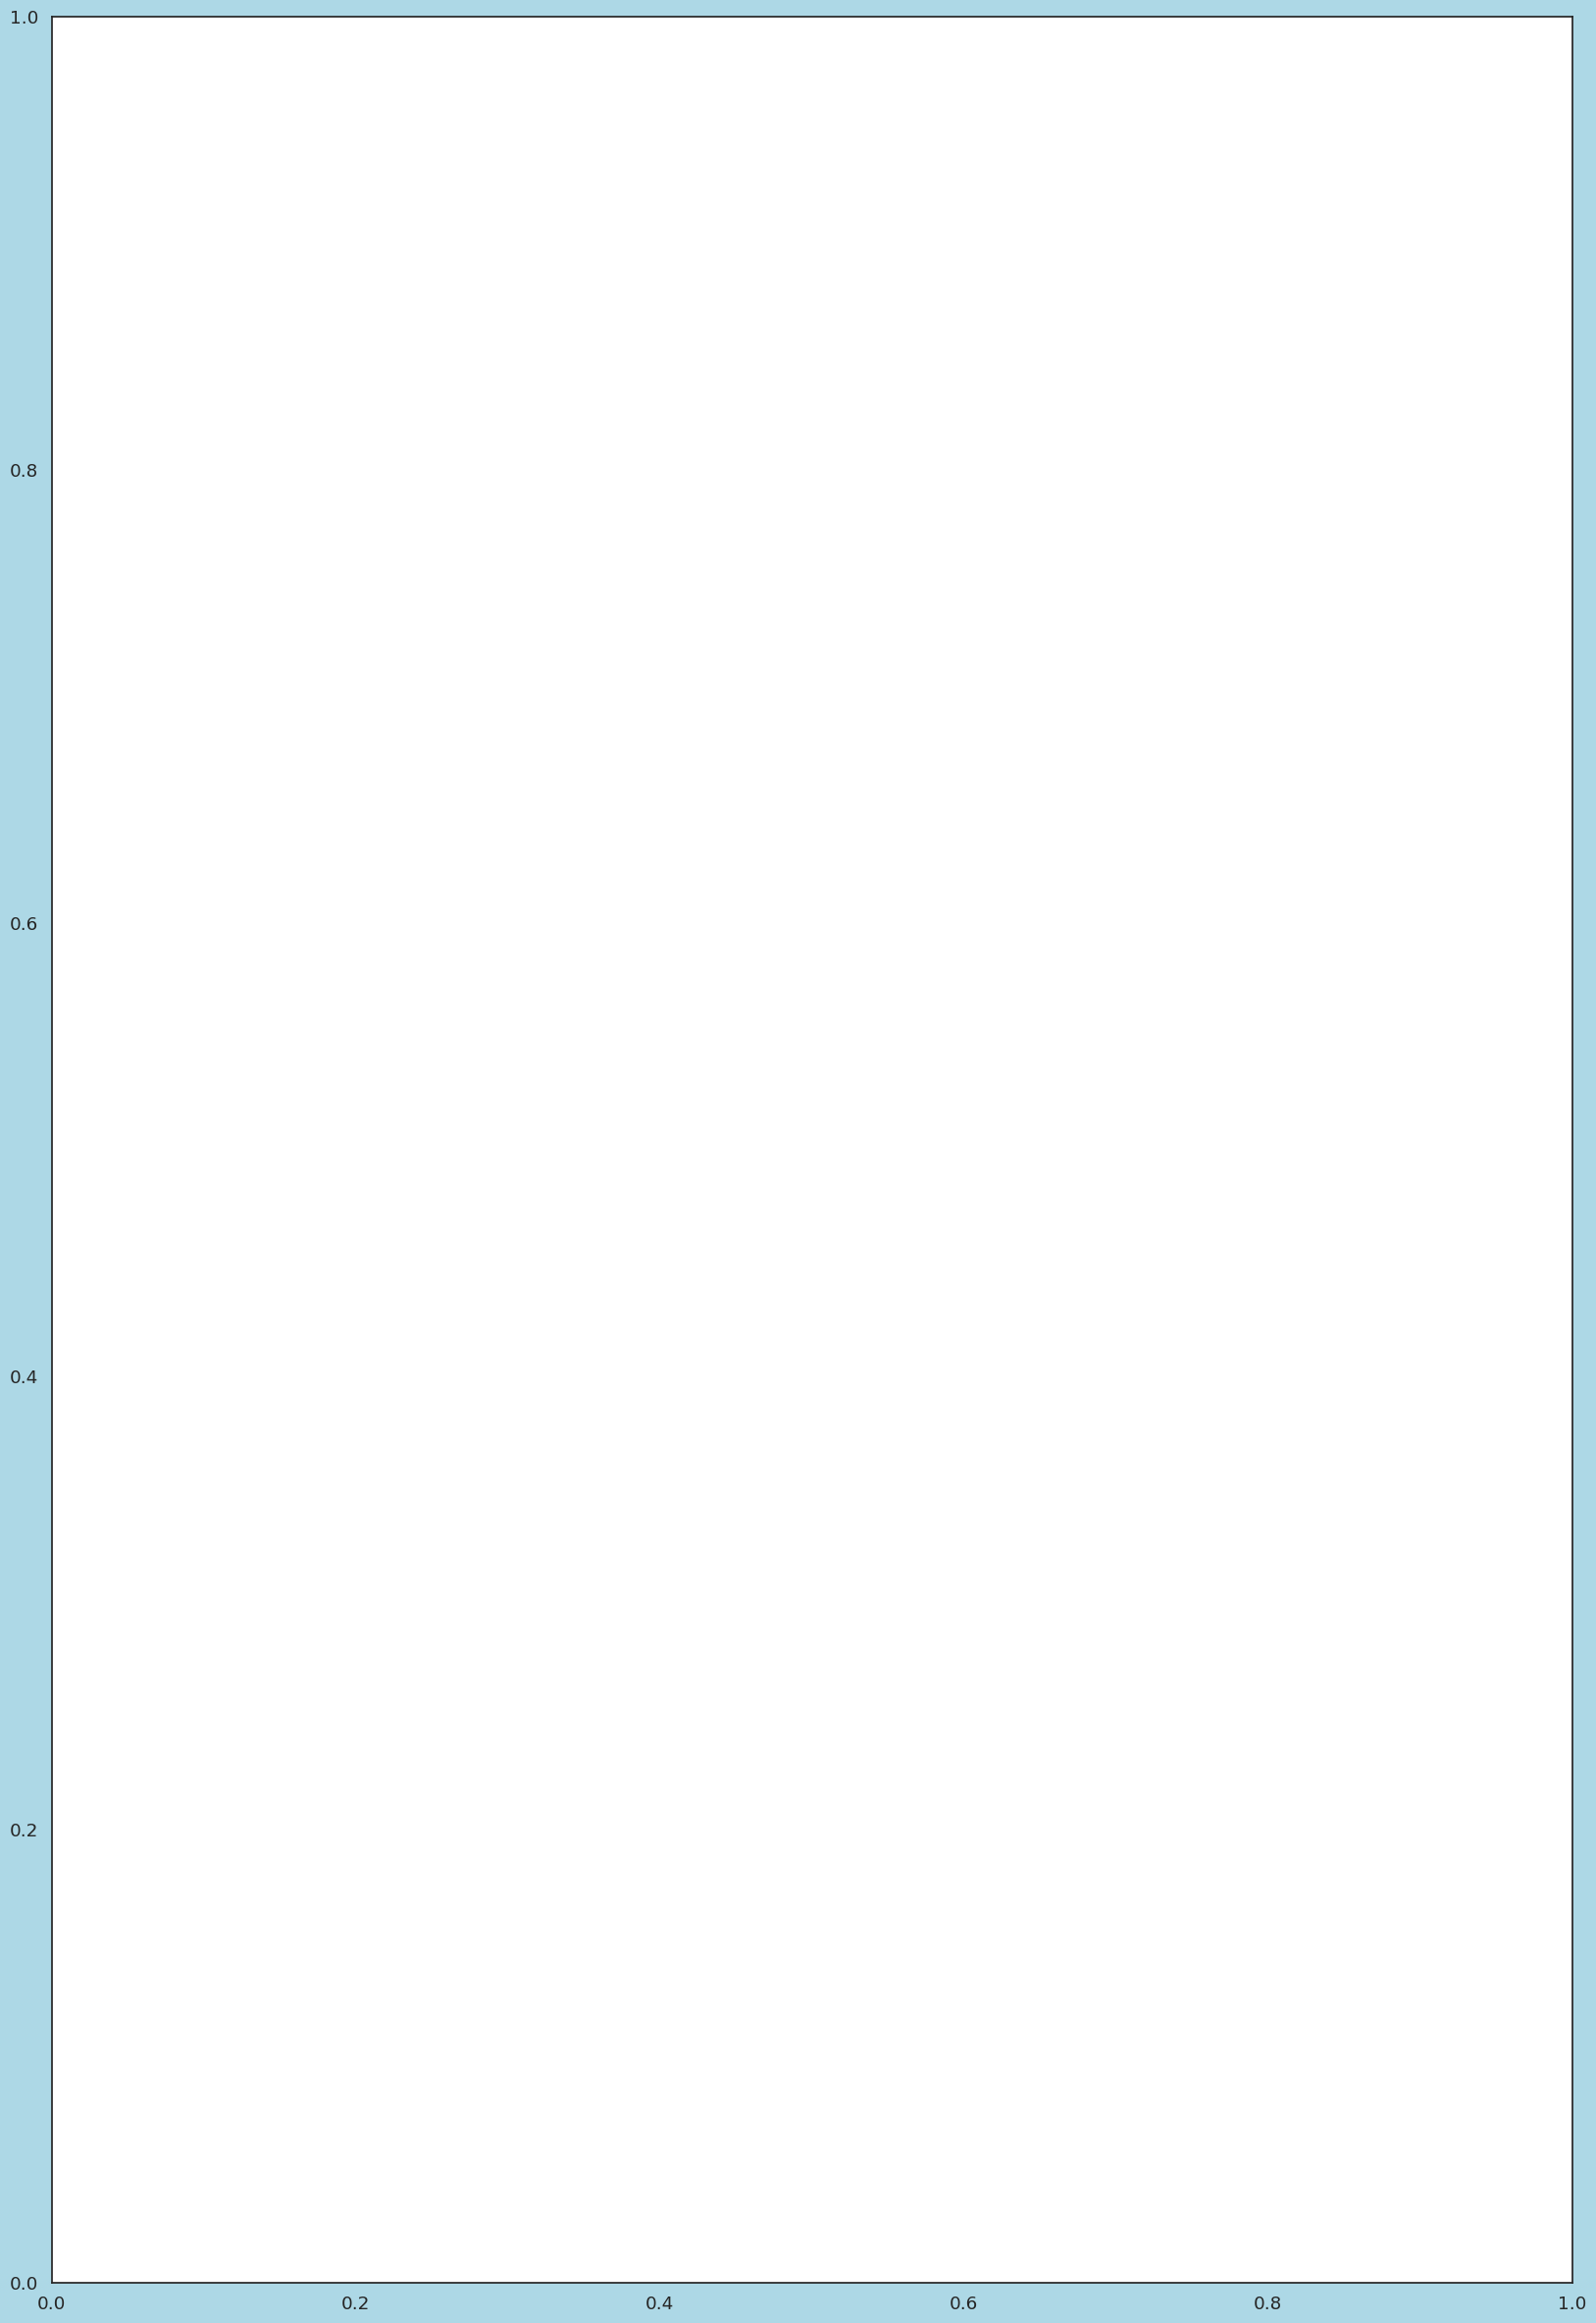

In [47]:
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("bright")
plt.rcParams['figure.facecolor'] = 'lightblue'
fig,ax = plt.subplots(figsize=(20,30))


Observation:

ph and sulfate features were judged to be important features.

In [48]:
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)

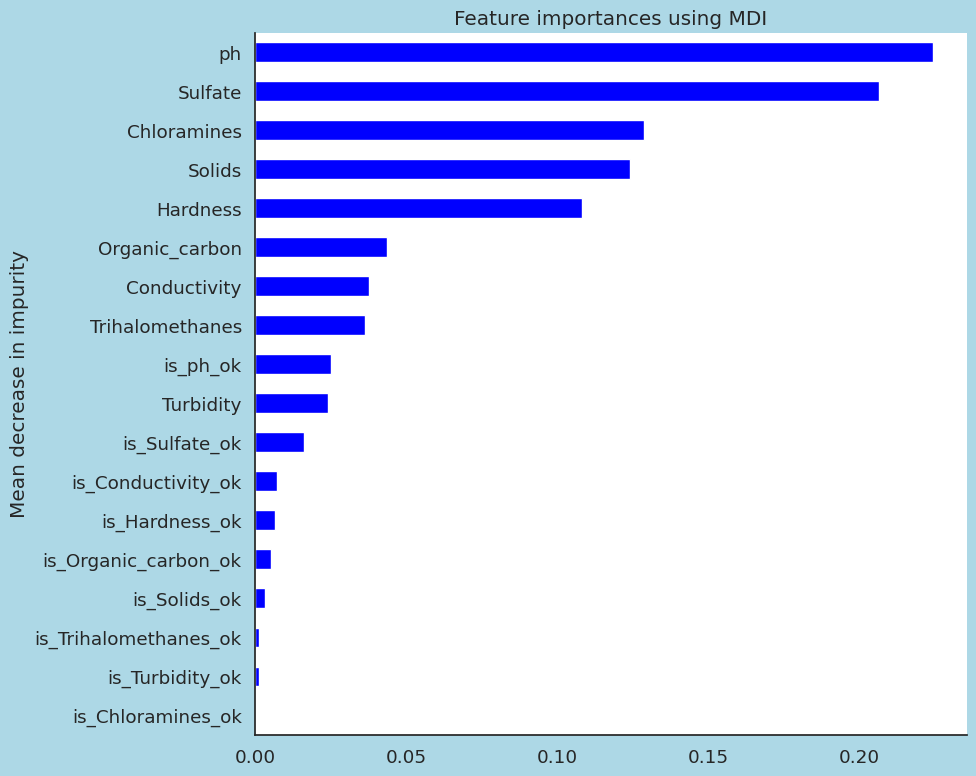

In [49]:
forest_importances = pd.Series(importances, index=all_cols)
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("bright")
plt.rcParams['figure.facecolor'] = 'lightblue'
fig, ax = plt.subplots(figsize=(10,8))
forest_importances.sort_values().plot.barh(yerr=std, ax=ax, color='blue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [50]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=all_cols)

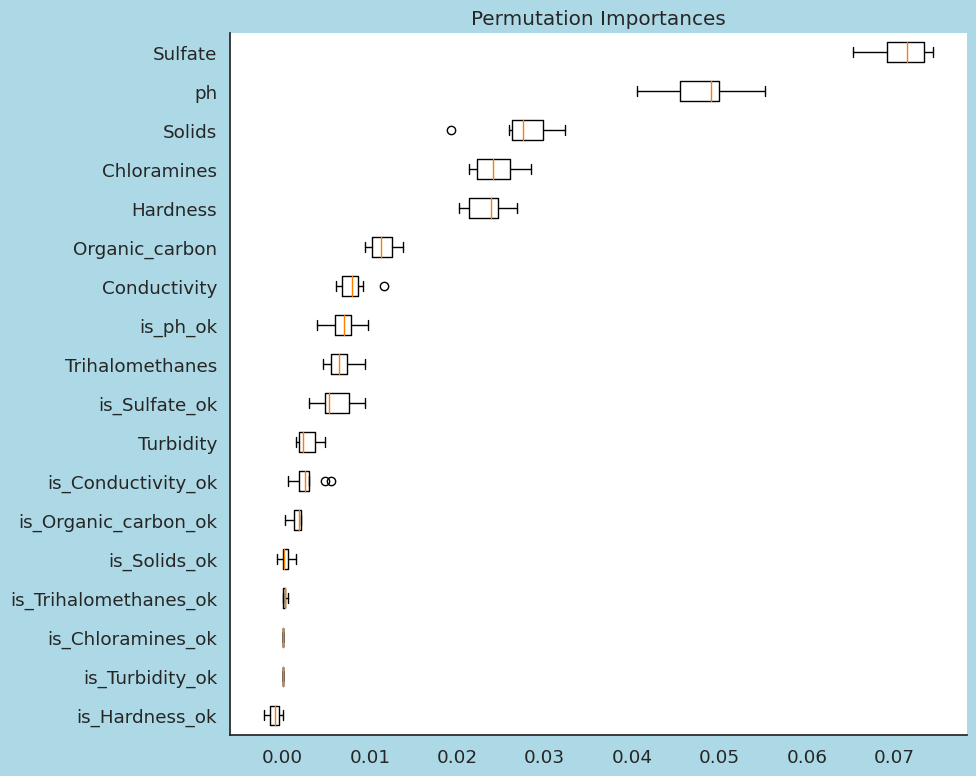

In [51]:
sorted_idx = result.importances_mean.argsort()
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("bright")
plt.rcParams['figure.facecolor'] = 'lightblue'
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

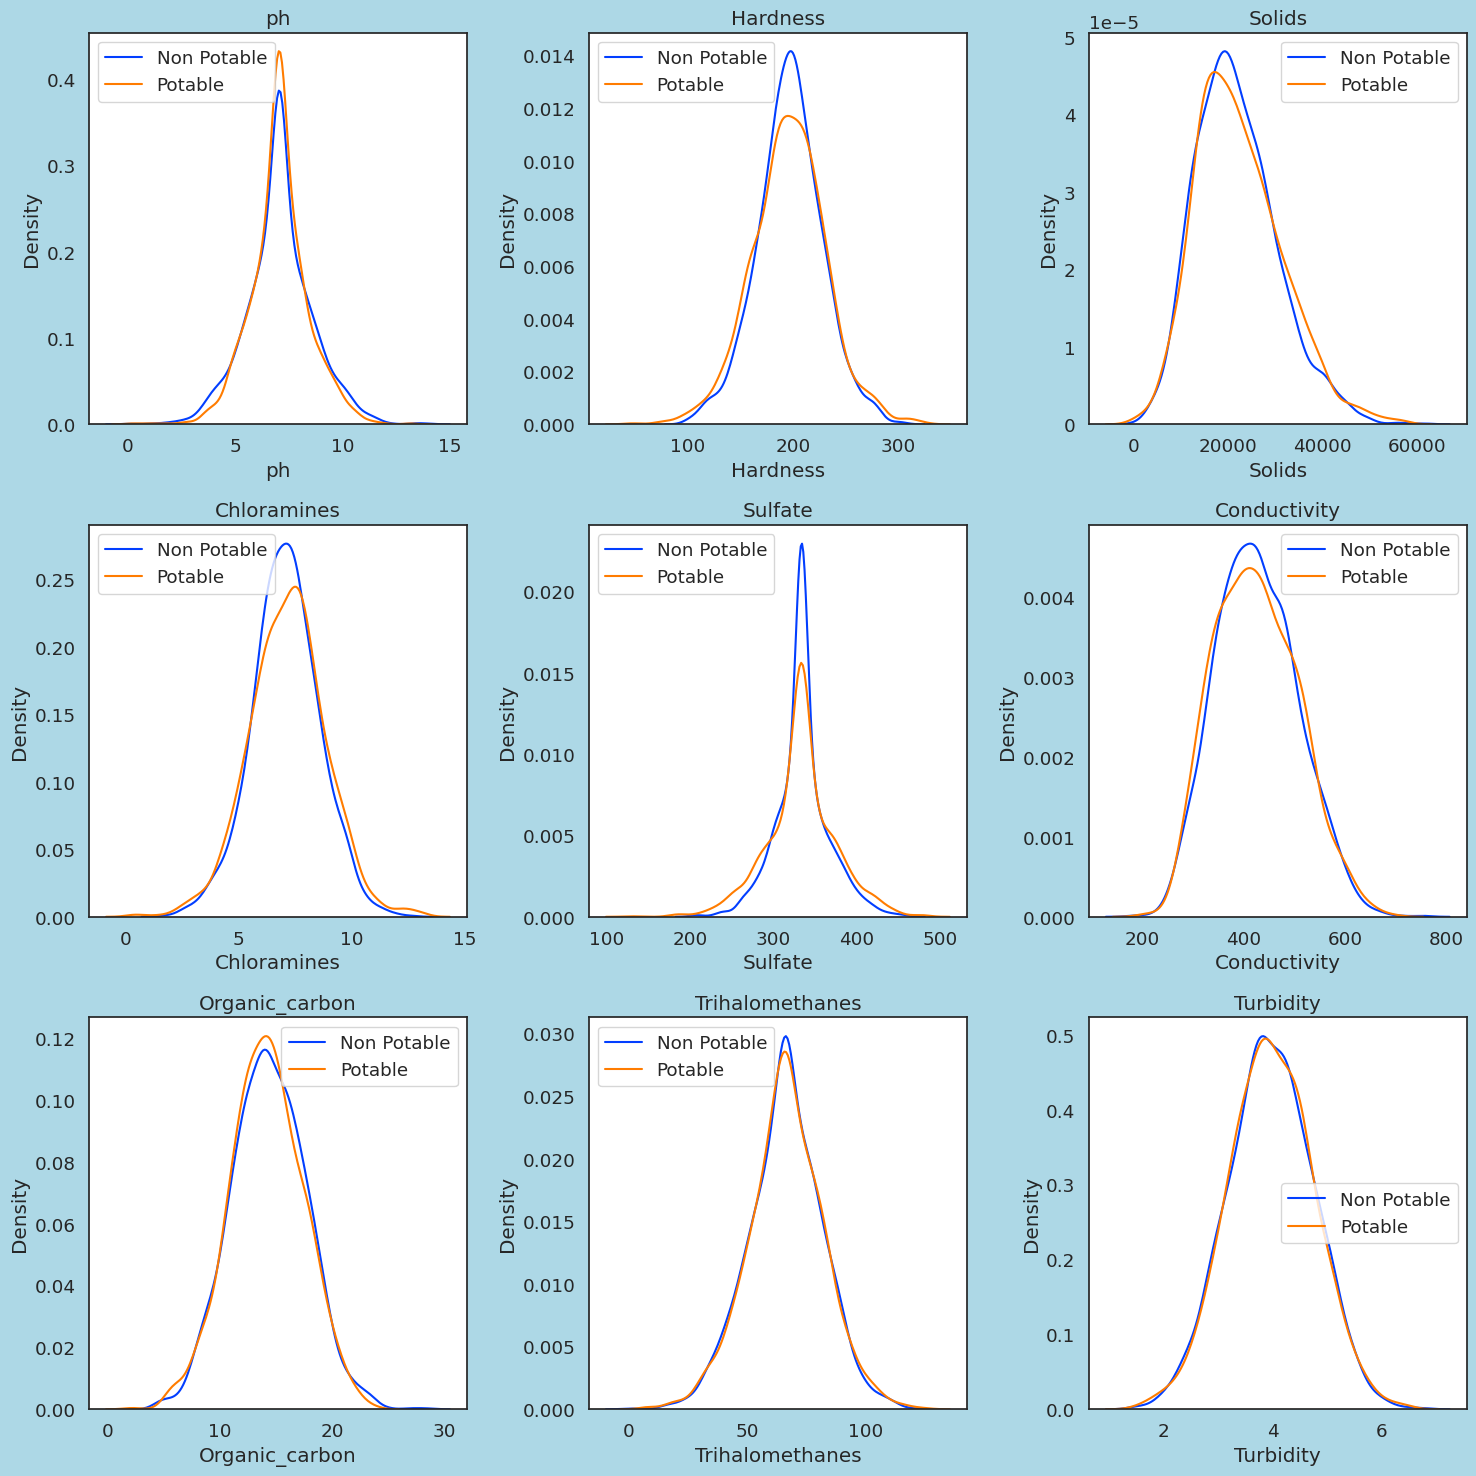

In [53]:
non_potable =water_df.query("Potability == 0")
potable = water_df.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax, col in enumerate(water_df.columns[:9]):
    plt.subplot(3,3, ax+1)
    plt.title(col)
    sns.kdeplot(x = non_potable[col], label = "Non Potable")
    sns.kdeplot(x = potable[col], label = "Potable")
    plt.legend()
plt.tight_layout()